In [1]:
from __future__ import division
from collections import defaultdict, OrderedDict
from copy import deepcopy
import random

import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.4 : Copyright (c) 2004-2011 Bo Peng
Revision 4950 (Nov 11 2014) for Python 2.7.8 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0x4620a9d8e878c782.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:
def kill(pop):
    kills = []
    for i in pop.individuals():
        if i.sex() == 1:
            cut = pop.dvars().survival_male[int(i.age)]
        else:
            cut = pop.dvars().survival_female[int(i.age)]
            if pop.dvars().gen > pop.dvars().cut_gen and i.age == 2:
                cut = 0
        if random.random() > cut:
            kills.append(i.ind_id)
    pop.removeIndividuals(IDs=kills)
    return True

In [3]:
def choose_parents(pop):
    #name convention required
    fathers = []
    mothers = []

    for ind in pop.individuals():
        if ind.sex() == 1:
            fathers.extend([ind] * pop.dvars().male_age_fecundity[int(ind.age)])
        else:
            ind.num_kids = 0
            mothers.append(ind)
    while True:
        father = random.choice(fathers)
        mother_ok = False
        while not mother_ok:
            mother = random.choice(mothers)
            if mother.num_kids < pop.dvars().max_kids[int(mother.age)]:
                mother.num_kids += 1
                mother_ok = True
        yield father, mother
        
def calc_demo(gen, pop):
    if gen > pop.dvars().cut_gen:
        add_females = len([ind for ind in pop.individuals([0, 2]) if ind.sex() == 2])
    else:
        add_females = 0
    return pop_size + pop.subPopSize([0, 3]) + add_females

In [4]:
mating_scheme = sp.HeteroMating([
    sp.HomoMating(
        sp.PyParentsChooser(choose_parents),
        sp.OffspringGenerator(numOffspring=1, ops=[
            sp.MendelianGenoTransmitter(), sp.IdTagger()]),
        weight=1),
    sp.CloneMating(weight=-1)],
    subPopSize=calc_demo)

In [5]:
pop_size = 300
num_loci = 50
num_alleles = 10
num_gens = 90
cut_gen = 50
#max_age = 3
max_kids = [0, 0, float('inf'), 1]
male_age_fecundity = [0, 0, 2, 1]
survival_male = [1, 0.8, 0.8, 0]
survival_female = [1, 0.9, 0.9, 0]

In [6]:
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['age', 'ind_id', 'num_kids'])
pops.setVirtualSplitter(sp.InfoSplitter(field='age', cutoff=[1, 2, 3]))

In [7]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [8]:
def init_age(pop):
    pop.dvars().male_age_fecundity = male_age_fecundity
    pop.dvars().survival_male = survival_male
    pop.dvars().survival_female = survival_female
    pop.dvars().max_kids = max_kids
    pop.dvars().cut_gen = cut_gen
    return True

In [9]:
def init_acumulators(pop, param):
    acumulators = param
    for acumulator in acumulators:
        pop.vars()[acumulator] = []
    return True

def update_pyramid(pop):
    pyr = defaultdict(int)
    for ind in pop.individuals():
        pyr[(int(ind.age), int(ind.sex()))] += 1
    pop.vars()['age_pyramid'].append(pyr)
    return True

def update_ldne(pop):
    pop.vars()['ldne'].append(pop.dvars().Ne_LD[0.05])
    return True

In [10]:
init_ops['Sex'] = sp.InitSex()
init_ops['ID'] = sp.IdTagger()
init_ops['acumulators'] = sp.PyOperator(init_acumulators, param=['ldne', 'age_pyramid'])
init_ops['Freq'] = sp.InitGenotype(freq=[1 / num_alleles] * num_alleles)
init_ops['Age-prepare'] = sp.PyOperator(init_age)
init_ops['Age'] = sp.InitInfo(lambda: random.randint(0, len(survival_male) - 1), infoFields='age')
pre_ops['Kill'] = sp.PyOperator(kill)
pre_ops['Age'] = sp.InfoExec('age += 1')
pre_ops['pyramid_acumulator'] = sp.PyOperator(update_pyramid)
post_ops['Ne'] = sp.Stat(effectiveSize=sp.ALL_AVAIL, subPops=[[0, 0]], vars=['Ne_LD'])
post_ops['Ne_acumulator'] = sp.PyOperator(update_ldne)
#post_ops['count'] = sp.PyEval(r'"gen %d, size %d\n" % (gen, pop.popSize())', exposePop='pop')

In [11]:
sim = sp.Simulator(pops, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(90L,)

In [12]:
ld_ne = sim.population(0).dvars().ldne
pyramid = sim.population(0).dvars().age_pyramid

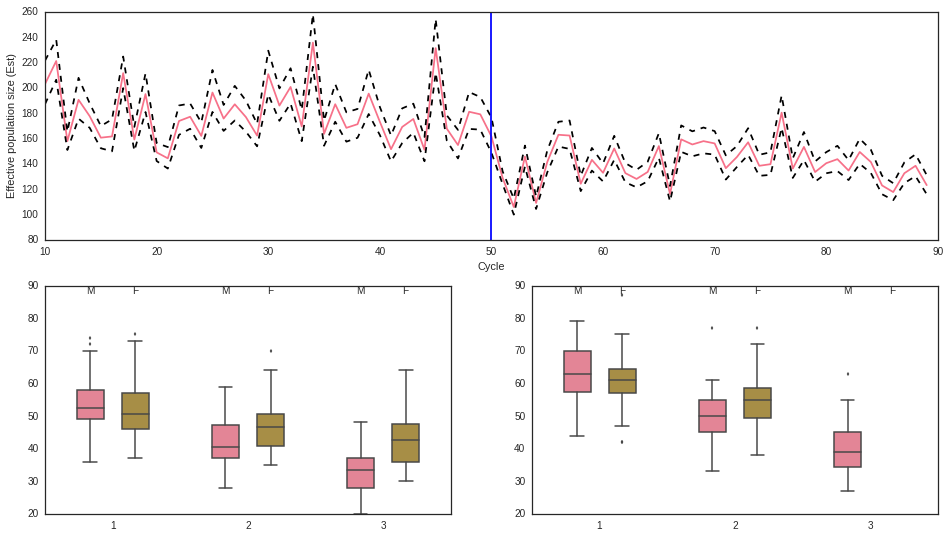

In [15]:
sns.set_palette('husl')

fig = plt.figure(figsize=(16, 9))
ax_ldne = fig.add_subplot(211)
ax_ldne.plot([x[0] for x in ld_ne[10:]])
ax_ldne.plot([x[1] for x in ld_ne[10:]], 'k--')
ax_ldne.plot([x[2] for x in ld_ne[10:]], 'k--')
ax_ldne.set_xticks(range(0, 81, 10))
ax_ldne.set_xticklabels([str(x) for x in range(10, 91, 10)])
ax_ldne.axvline(cut_gen - 10)
ax_ldne.set_xlabel('Cycle')
ax_ldne.set_ylabel('Effective population size (Est)')

def plot_pyramid(ax_bp, pyramids):
    bp_data = [([], []) for group in range(3)]
    for my_pyramid in pyramids:
        for (age, sex), cnt in my_pyramid.items():
            bp_data[age - 1][sex - 1].append(cnt)
    for group in range(3):
        bp = sns.boxplot(bp_data[group], positions=[group * 3 + 1, group * 3 + 2], widths=0.6, ax=ax_bp)
        ax_bp.text(1 + 3 * group, 90, 'M', va='top', ha='center')
        ax_bp.text(2 + 3 * group, 90, 'F', va='top', ha='center')
    ax_bp.set_xlim(0, 9)
    ax_bp.set_ylim(20, 90)
    ax_bp.set_xticklabels(['1', '2', '3'])
    ax_bp.set_xticks([1.5, 4.5, 7.5])
    ax_bp.legend()

pre_decline = pyramid[10:50]
post_decline = pyramid[51:]


ax_bp = fig.add_subplot(2, 2, 3)
plot_pyramid(ax_bp, pre_decline)


ax_bp = fig.add_subplot(2, 2, 4)
plot_pyramid(ax_bp, post_decline)

In [14]:
print post_decline[10]

defaultdict(<type 'int'>, {(1, 2): 65, (3, 1): 44, (1, 1): 64, (2, 1): 45, (2, 2): 55})
